In [1]:
%matplotlib inline
import os
import os.path as osp
import pandas as pd
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
from tcre.env import *
from tcre import supervision 
classes = supervision.get_candidate_classes()

In [2]:
res_parts = [
    (osp.join(RESULTS_DATA_DIR, 'modeling-lfs', 'run2'), 'est-strong'),
    (osp.join(RESULTS_DATA_DIR, 'modeling-rnn-strong', 'run4'), 'rnn-strong'),
    (osp.join(RESULTS_DATA_DIR, 'modeling-rnn-weak', 'run6'), 'rnn-weak'),
    (osp.join(RESULTS_DATA_DIR, 'modeling-bert', 'run1'), 'bert')
]

### Validate Splits

In [3]:
# Load the candidate ids used in training (+validation, +test) for each modeling strategy and task
df = pd.concat([
    pd.read_json(osp.join(p[0], classes[c].field, 'splits', 'splits.json'), orient='index', typ='series')
    .rename('ids').rename_axis('split').reset_index()
    .assign(task=classes[c].field, grp=p[1])
    for p in res_parts    
    for c in classes
    if 'bert' not in p[-1]
]).reset_index(drop=True)
df.head()

,split,ids,task,grp
0,test,"[37662, 51942, 87961, 72989, 6283, 66210, 6909...",inducing_cytokine,est-strong
1,train,"[83055, 31921, 85221, 75942, 23468, 21710, 664...",inducing_cytokine,est-strong
2,val,"[66627, 19079, 45383, 15479, 81022, 40367, 722...",inducing_cytokine,est-strong
3,test,"[153108, 171992, 101611, 167092, 114925, 15100...",secreted_cytokine,est-strong
4,train,"[164437, 172453, 171932, 158311, 167808, 16995...",secreted_cytokine,est-strong


In [4]:
# Verify that across the different modeling strategies, the candidate ids used for validation and test are identical
# (training ids may differ depending on the strategy)
cts = (
    df[df['split'].isin(['test', 'val'])]
    .assign(ids=lambda df: df['ids'].apply(lambda ids: ','.join(map(str, sorted(ids)))))
    .groupby(['task', 'split'])['ids'].nunique()
)
assert (cts == 1).all()
cts

task                           split
inducing_cytokine              test     1
                               val      1
inducing_transcription_factor  test     1
                               val      1
secreted_cytokine              test     1
                               val      1
Name: ids, dtype: int64

In [5]:
del cts
del df

### Load Scores

In [6]:
df = pd.concat([
    pd.read_csv(osp.join(p[0], 'scores.csv')).assign(grp=p[1])
    for p in res_parts
], sort=True)
df.head()

,grp,metric,model,split,task,value
0,est-strong,f1,gbr,validation,inducing_cytokine,0.727273
1,est-strong,accuracy,gbr,validation,inducing_cytokine,0.739130
2,est-strong,precision,gbr,validation,inducing_cytokine,0.761905
3,est-strong,recall,gbr,validation,inducing_cytokine,0.695652
4,est-strong,roc_auc,gbr,validation,inducing_cytokine,0.880907


In [7]:
df.groupby(['task', 'grp', 'split'])['metric'].nunique().unstack()

split                                     test  training  validation
task                          grp                                   
inducing_cytokine             bert           7         7           7
                              est-strong     6         6           6
                              rnn-strong    11        11          11
                              rnn-weak      11        11          11
inducing_transcription_factor bert           7         7           7
                              est-strong     6         6           6
                              rnn-strong    11        11          11
                              rnn-weak      11        11          11
secreted_cytokine             bert           7         7           7
                              est-strong     6         6           6
                              rnn-strong    11        11          11
                              rnn-weak      11        11          11

In [8]:
def get_plot(df, metric, rand_baseline=.5, pos_baseline=.66):
    return (
        pn.ggplot(
            df
                .pipe(lambda df: df[df['metric'] == metric])
                .assign(model=lambda df: pd.Categorical(
                    df['model'], ordered=True, 
                    # Average across tasks
                    categories=df[df['split'] == 'test'].groupby(['metric', 'model'])['value'].mean().loc[metric].sort_values().index
                ))
                .assign(type=lambda df: df['grp'].map({
                    'rnn-weak': 'RNN (Weak)',
                    'rnn-strong': 'RNN (Strong)',
                    'est-strong': 'Sentence-Level Models',
                    'bert': 'BERT'
                }))
                .assign(label=lambda df: df['value'].apply(lambda v: f'{100*v:.1f}'))
            ,
            pn.aes(x='model', y='value', fill='type', label='label')
        ) + 
        pn.geom_bar(stat='identity', position='dodge', alpha=.5) +
        pn.geom_text(va='top', size=10) + 
        pn.facet_grid('task ~ split') +
        pn.coord_cartesian(ylim = (.45, 1)) + 
        pn.geom_hline(yintercept=pos_baseline, linetype='solid') + 
        pn.geom_hline(yintercept=rand_baseline, linetype='dashed') +
        pn.theme_bw() + 
        pn.theme(figure_size=(16, 8), axis_text_x=pn.element_text(rotation=90))
    )

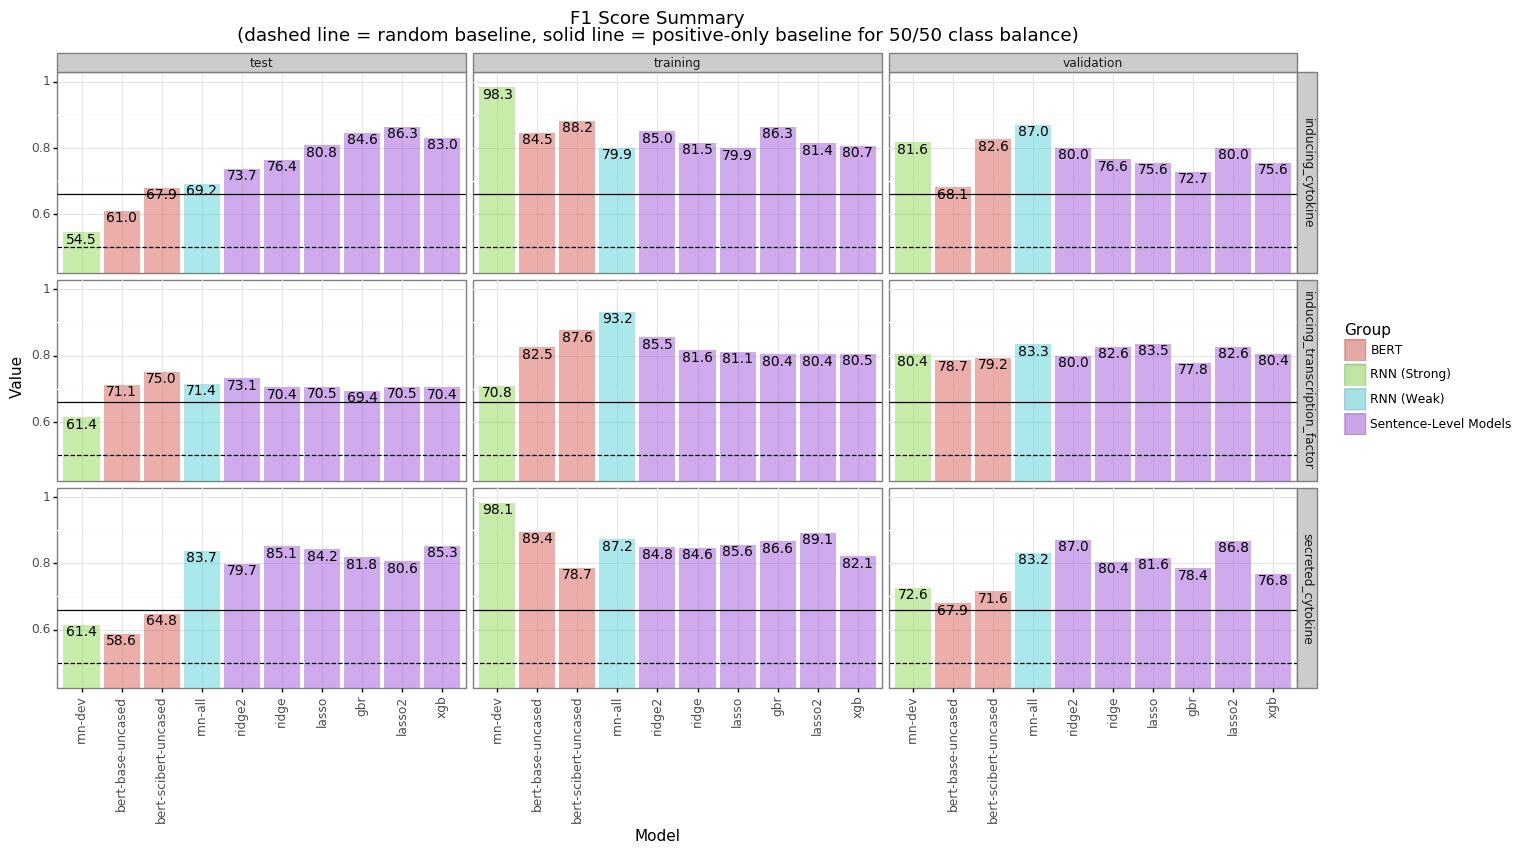

<ggplot: (-9223363243721526412)>

In [9]:
get_plot(df, 'f1') + pn.labs(
    x='Model', y='Value', fill='Group',
    title='F1 Score Summary\n(dashed line = random baseline, solid line = positive-only baseline for 50/50 class balance)'
)

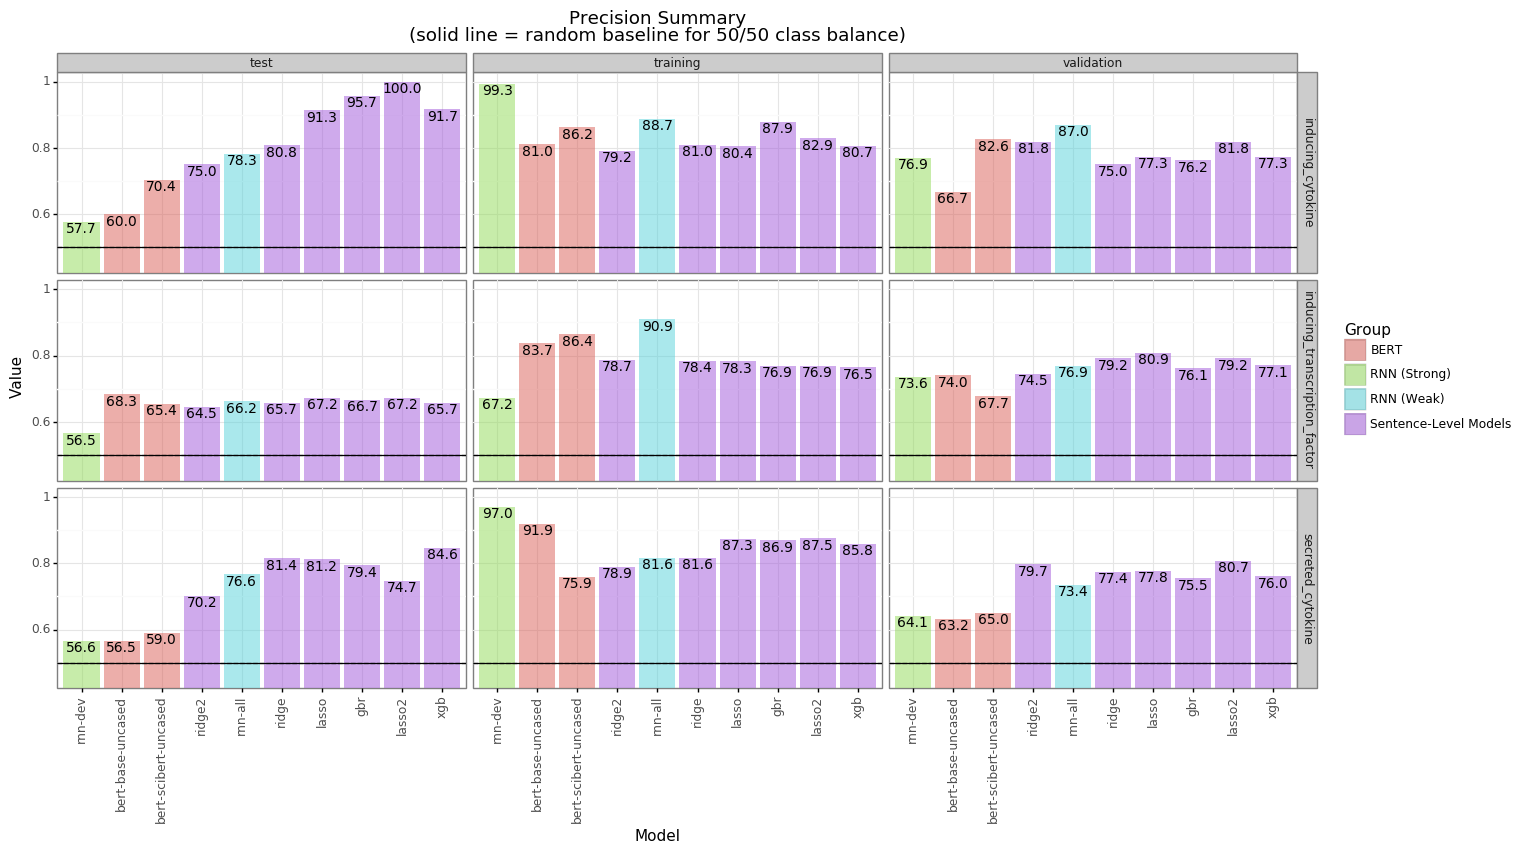

<ggplot: (-9223363243773613382)>

In [10]:
get_plot(df, 'precision', pos_baseline=.5) + pn.labs(
    x='Model', y='Value', fill='Group',
    title='Precision Summary\n(solid line = random baseline for 50/50 class balance)'
)

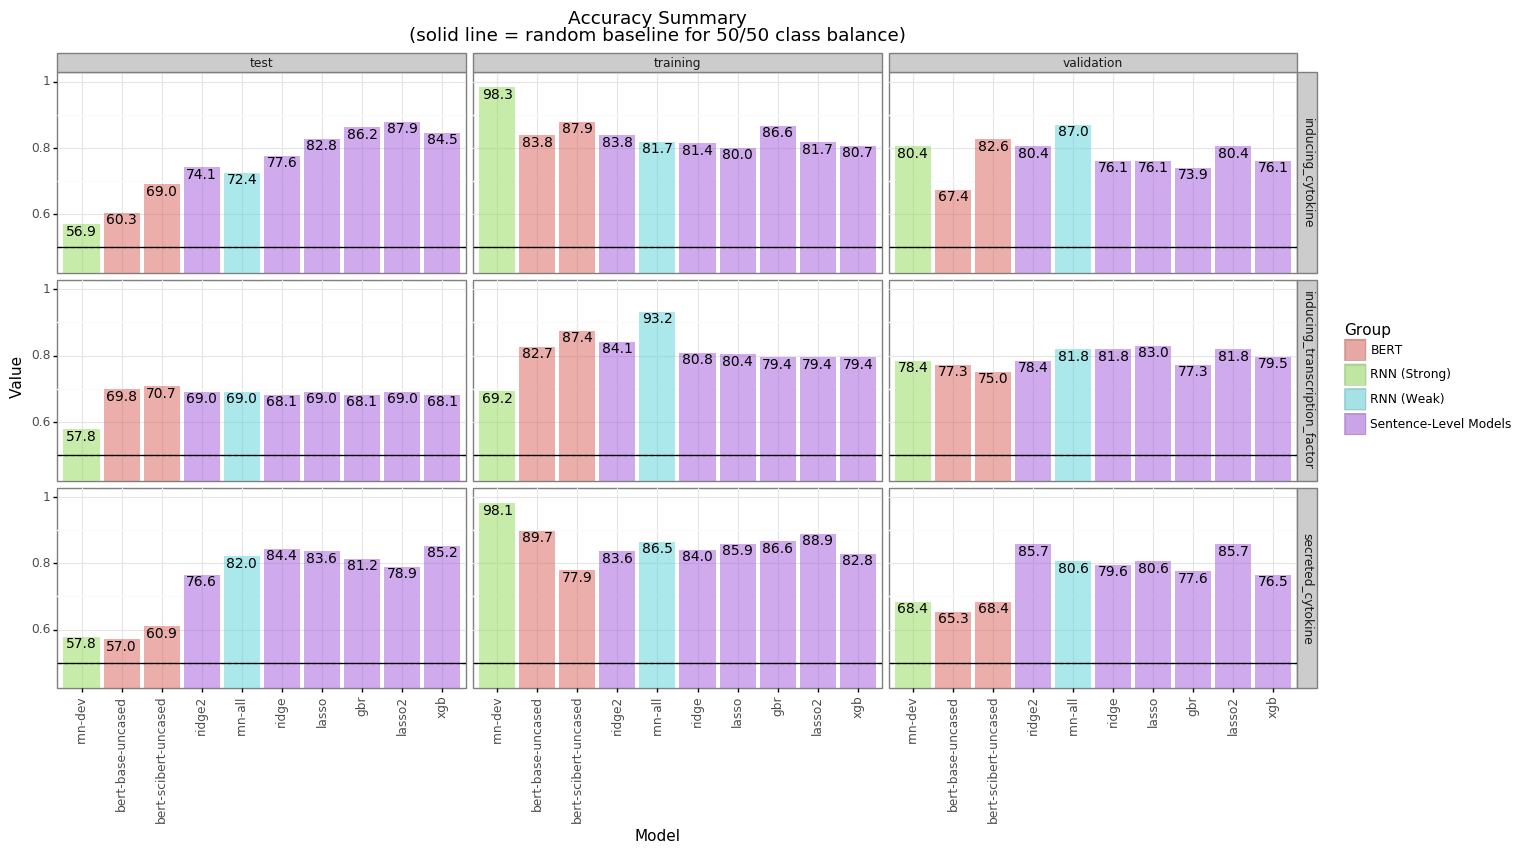

<ggplot: (-9223363243812435196)>

In [11]:
get_plot(df, 'accuracy', pos_baseline=.5) + pn.labs(
    x='Model', y='Value', fill='Group',
    title='Accuracy Summary\n(solid line = random baseline for 50/50 class balance)'
)

In [12]:
def get_plot(df, split, metrics):
    return (
        pn.ggplot(
            df
                .pipe(lambda df: df[df['split'] == split])
                .pipe(lambda df: df[df['metric'].isin(metrics)])
                .assign(model=lambda df: pd.Categorical(
                    df['model'], ordered=True, 
                    # Average across tasks
                    categories=df[df['metric'] == 'f1'].groupby(['metric', 'model'])['value'].mean().loc['f1'].sort_values().index
                ))
                .assign(type=lambda df: df['grp'].map({
                    'rnn-weak': 'RNN (Weak)',
                    'rnn-strong': 'RNN (Strong)',
                    'est-strong': 'Sentence-Level Models',
                    'bert': 'BERT'
                }))
                .assign(label=lambda df: df['value'].apply(lambda v: f'{100*v:.1f}'))
            ,
            pn.aes(x='model', y='value', fill='type', label='label')
        ) + 
        pn.geom_bar(stat='identity', position='dodge', alpha=.5) +
        pn.geom_text(va='top', size=10) + 
        pn.facet_grid('task ~ metric') +
        pn.coord_cartesian(ylim = (.45, 1)) + 
        pn.theme_bw() + 
        pn.theme(figure_size=(16, 8), axis_text_x=pn.element_text(rotation=90))
    )

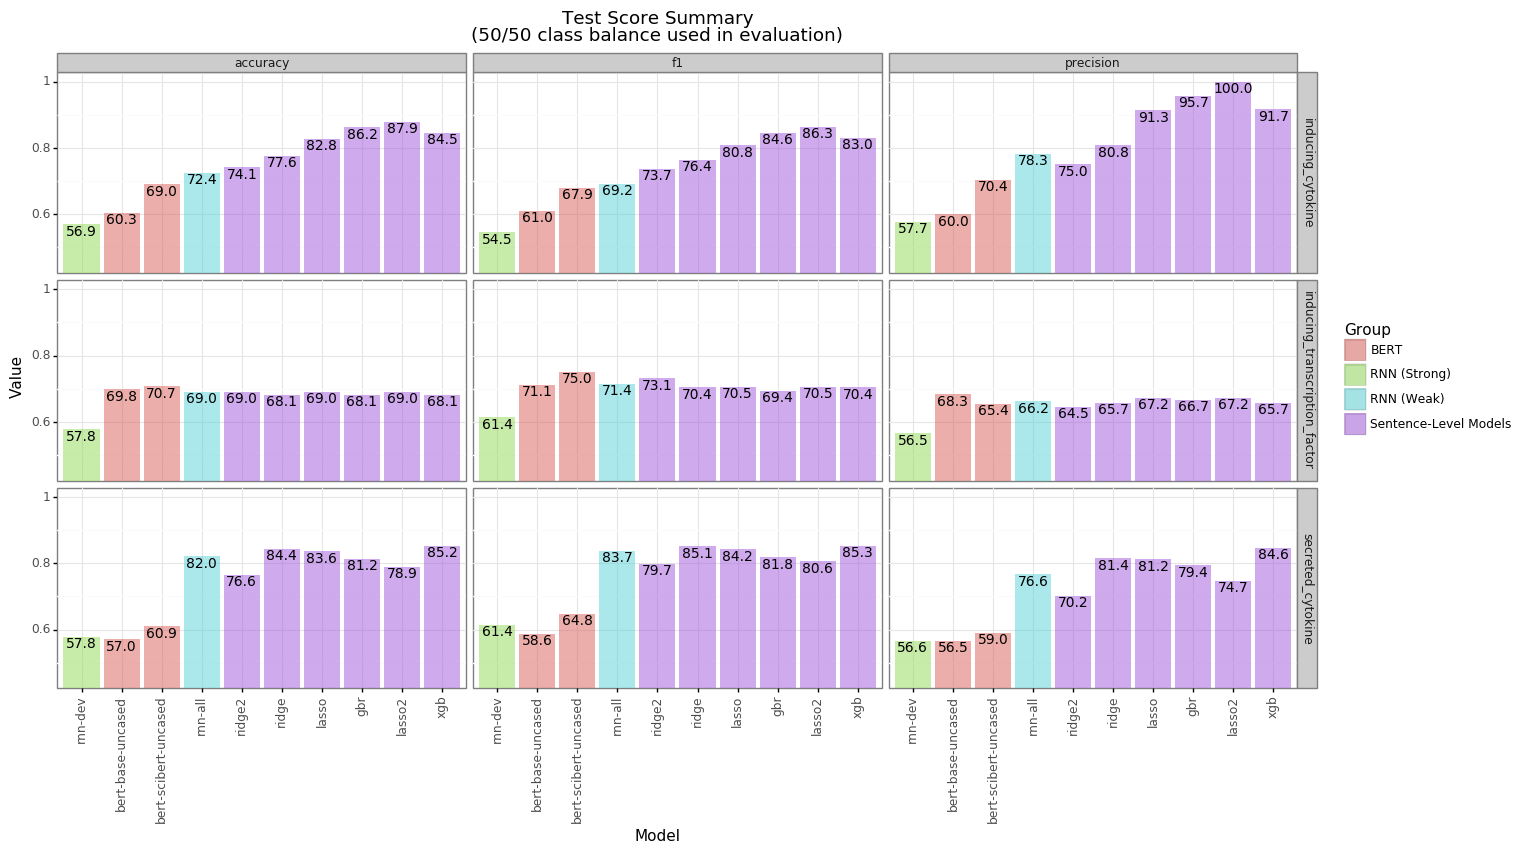

<ggplot: (8793039818728)>

In [13]:
get_plot(df, 'test', ['f1', 'accuracy', 'precision']) + pn.labs(
    x='Model', y='Value', fill='Group',
    title='Test Score Summary\n(50/50 class balance used in evaluation)'
)